In [2]:
%reload_ext autoreload
%autoreload 2
from ift6758.data import goalsCoordinates, GameBuilder, get_shooter_or_scorer_and_goalie, none_to_na
import pandas as pd
import json
import os
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

In [3]:
def load_game(gameNum):
    import json
    
    with open(f'{datasetsFolder}{gameNum}.json', 'r') as file:
        game_data = file.read()

    return GameBuilder().build(json.loads(game_data))

datasetsFolder = '../dataset/'
fullGameList = [int(fileName[:10]) for fileName in os.listdir(datasetsFolder)]

def get_shots_goals_events(game):
    events = game.events
    eventFilterLambda = lambda event: event.eventTypeId in ['GOAL', 'SHOT']
    return list(filter(eventFilterLambda, events))


def get_coordinates_side(rinkSide, eventCoordinates):
    if rinkSide is not None:
        return rinkSide
    elif 'x' in eventCoordinates:
        if eventCoordinates['x'] < 0:
            return 'left'
        else:
            return 'right'

    return None


def get_opponent_goal_coordinates(shooterTeam, homeTeamTriCode, eventCoordinates, eventPeriodNumber, periodsDict):
    if eventPeriodNumber not in periodsDict:
        #SHOOTOUT period
        if 'x' not in eventCoordinates:
            return None
        elif eventCoordinates['x'] < 0:
            return goalsCoordinates['left']
        else:
            return goalsCoordinates['right']

    currentPeriod = periodsDict[eventPeriodNumber]
    rinkSide = None
    if homeTeamTriCode == shooterTeam:
        rinkSide = get_coordinates_side(currentPeriod.awayTeamRinkSide, eventCoordinates)
    else:
        rinkSide = get_coordinates_side(currentPeriod.homeTeamRinkSide, eventCoordinates)
    
    return goalsCoordinates[rinkSide] if rinkSide is not None else None


def events_list_to_dataFrame(gameId, game):
    eventsList = game.events
    homeTeam = game.homeTeam
    awayTeam = game.awayTeam
    periodsDict = game.periods
    data = []
    for event in eventsList:
        shooterOrScorer, goalie = get_shooter_or_scorer_and_goalie(event.players)
        shooterTeam = event.shooterTeam
        homeTeamTriCode = homeTeam.triCode
        eventCoordinates = event.coordinates
        opponentGoal = get_opponent_goal_coordinates(shooterTeam, homeTeamTriCode,\
                                                     eventCoordinates, event.periodNumber, periodsDict)
        data.append({'Game' : gameId,
                     'Type' : event.eventTypeId,
                     'Secondary Type' : event.secondaryType,
                     'Period' : event.periodNumber,
                     'Period Time' : event.periodTime,
                     'Remaining Time' : event.periodRemainingTime,
                     'Home Team' : homeTeamTriCode,
                     'Away Team' : awayTeam.triCode,
                     'Home Team Shorthanded' : awayTeam.powerPlay,
                     'Away Team Shorthanded' : homeTeam.powerPlay,
                     'Shooter/Scorer Team' : shooterTeam,
                     'Shooter/Scorer' : shooterOrScorer.fullName,
                     'Goalie' : none_to_na(goalie, 'fullName'),
                     'Shooter/Scorer X Coordinate' : none_to_na(eventCoordinates, 'x'),
                     'Shooter/Scorer Y Coordinate' : none_to_na(eventCoordinates, 'y'),
                     'Opponent Goal X Coordinate' : none_to_na(opponentGoal, 'x'),
                     'Opponent Goal Y Coordinate' : none_to_na(opponentGoal, 'y')
                  })

    return pd.DataFrame(data)

gamesList = fullGameList

df = pd.DataFrame({})
for gameId in gamesList:
    currentGame = load_game(gameId)
    currentGame.events = get_shots_goals_events(currentGame)
    df = df.append(events_list_to_dataFrame(gameId, currentGame), ignore_index=True)


**Q1/** \
Produce a histogram OR BARPLOT of shot types over all teams in a season of your choosing. Overlay the number of goals overtop the number of shots. What appears to be the most dangerous type of shot? The most common type of shot? Add this figure and discussion to your blog post.

In [4]:
df['Season'] = df.Game.astype(str).str[:4] + '/' + (df.Game.astype(str).str[:4].astype(int) + 1).astype(str)

In [5]:
df_2018_2019 = df[df.Season == '2018/2019']

In [6]:
df_grouped_shots = df_2018_2019.groupby(['Secondary Type', 'Type'])

In [7]:
ids = df_grouped_shots.size().index

In [8]:
df_grouped_shots.size()

Secondary Type  Type
Backhand        GOAL      825
                SHOT     6178
Deflected       GOAL      264
                SHOT     1415
Slap Shot       GOAL      783
                SHOT    11465
Snap Shot       GOAL     1213
                SHOT    10755
Tip-In          GOAL      770
                SHOT     3731
Wrap-around     GOAL       60
                SHOT      827
Wrist Shot      GOAL     4328
                SHOT    43316
dtype: int64

In [9]:
shot_types = list(set([id[0] for id in ids]))

/Users/paulvilledieu/UDEMProjects/6758/.env/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/paulvilledieu/UDEMProjects/6758/.env/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


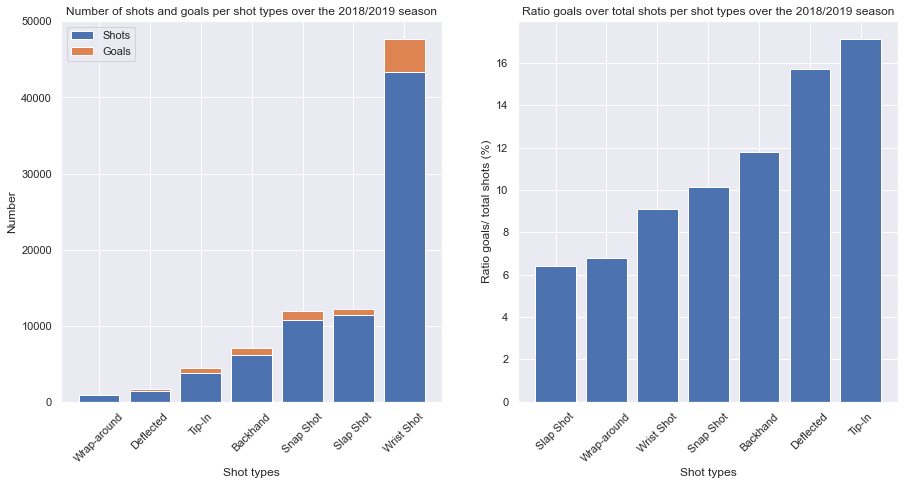

In [10]:
labels = shot_types
shots = df_grouped_shots.Game.count().loc[shot_types, 'SHOT'].values
goals = df_grouped_shots.Game.count().loc[shot_types, 'GOAL'].values
totals = shots + goals
labels_sorted = [x for _, x in sorted(zip(totals, labels))]
shots_sorted = [x for _, x in sorted(zip(totals, shots))]
goals_sorted = [x for _, x in sorted(zip(totals, goals))]

ratios = goals * 100 / totals
labels_sorted_2 = [x for _, x in sorted(zip(ratios, labels))]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.bar(labels_sorted, shots_sorted, label='Shots')
ax1.bar(labels_sorted, goals_sorted, bottom=shots_sorted,
       label='Goals')
ax1.set_xlabel('Shot types')
ax1.set_ylabel('Number')
ax1.set_title('Number of shots and goals per shot types over the 2018/2019 season')
ax1.legend()
ax1.set_xticklabels(labels_sorted, rotation=45)

ax2.bar(labels_sorted_2, sorted(ratios))
ax2.set_xlabel('Shot types')
ax2.set_ylabel('Ratio goals/ total shots (%)')
ax2.set_title('Ratio goals over total shots per shot types over the 2018/2019 season')
ax2.set_xticklabels(labels_sorted_2, rotation=45)
fig.savefig('5-1.png')
plt.show()

**Answer**

*Nous pouvons voir grâce au premier graphique que le "Wrist Shot" est de loin le tir le plus utilisé par les équipes sur la saison 2018/2019 avec presque 50.000 tentatives. Cependant, ce n'est pas le tir le plus dangereux. En effet, grâce au second graphique, nous constatons que le "Tip-in" présente un pourcentage de tirs convertis en but d'environ 17%. Le "Wrist Shot" ne présente quant à lui que seulement 9% de conversion.*

**Q2/** \
What is the relationship between the distance a shot was taken and the chance it was a goal? Produce a figure for each season between 2018-19 to 2020-21 to answer this, and add it to your blog post along with a couple of sentences describing your figure. Has there been much change over the past three seasons? Note: there are multiple ways to show this relationship! If your figure tells the correct story, you will get full marks.

In [11]:
df_2018_to_2020 = df[df.Season.isin(['2018/2019', '2019/2020', '2020/2021'])].dropna()

In [12]:
df_2018_to_2020['Shooter/Scorer Coordinate'] = list(zip(df_2018_to_2020['Shooter/Scorer X Coordinate'], df_2018_to_2020['Shooter/Scorer Y Coordinate']))

In [13]:
df_2018_to_2020['Opponent Goal Coordinate'] = list(zip(df_2018_to_2020['Opponent Goal X Coordinate'], df_2018_to_2020['Opponent Goal Y Coordinate']))

In [14]:
a = np.dstack((df_2018_to_2020['Shooter/Scorer X Coordinate'], df_2018_to_2020['Shooter/Scorer Y Coordinate']))[0]

In [15]:
b = np.dstack((df_2018_to_2020['Opponent Goal X Coordinate'], df_2018_to_2020['Opponent Goal Y Coordinate']))[0]

In [16]:
df_2018_to_2020['Shot Distance'] = np.linalg.norm(a-b, axis=1)

In [17]:
distance_bins = list(range(0, 200, 15))

In [18]:
df_2018_to_2020['Shot Distance Binned'] = pd.cut(df_2018_to_2020['Shot Distance'], distance_bins)

In [19]:
df_grouped = df_2018_to_2020.groupby(['Season', 'Shot Distance Binned', 'Type']).size()

In [20]:
df_grouped_totals = df_grouped.groupby(level=[0, 1]).sum()

In [21]:
def get_values_from_season(season):
    goals_ = df_grouped.loc[season, :, 'GOAL'].values
    totals_ = df_grouped_totals[season].values
    return goals_ * 100 / totals_

/Users/paulvilledieu/UDEMProjects/6758/.env/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


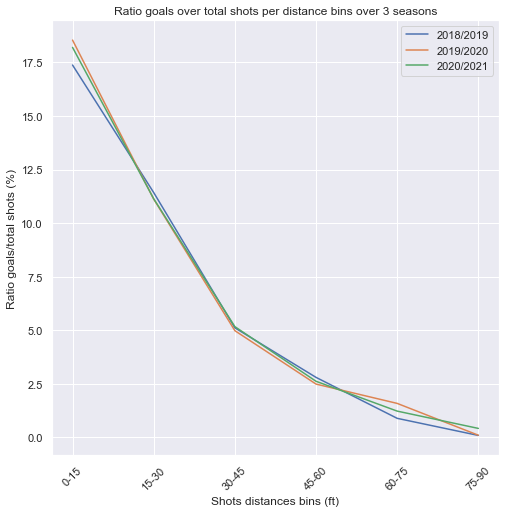

In [22]:
seasons = ['2018/2019', '2019/2020', '2020/2021']
labels = ['{}-{}'.format(bin, bin+15) for bin in distance_bins[:6]]

fig, ax = plt.subplots(figsize=(8, 8))
for season in seasons:
    ax.plot(labels, get_values_from_season(season)[:len(labels)], label=season)

ax.set_xlabel('Shots distances bins (ft)')
ax.set_ylabel('Ratio goals/total shots (%)')
ax.set_title('Ratio goals over total shots per distance bins over 3 seasons')
ax.legend()
ax.set_xticklabels(labels, rotation=45)
fig.savefig('5-2.png')

plt.show()

**Answer**

*En comparant les ratios de buts par rapport au nombre de tirs nous constatons que ceux-ci sont plutôt très similaires sur les 3 saisons de 2018 à 2021. À noter que nous avons décider de ne pas utiliser les données de tirs/buts au delà de 90ft car le nombre de tirs étaient beaucoup trop faible et non représentatif au niveau du ratio de conversion buts/tirs.*

**Q3/** \
Combine the information from the previous sections to produce a figure that shows the goal percentage (# goals / # shots) as a function of both distance from the net, and the category of shot types (you can pick a single season of your choice). Briefly discuss your findings; e.g. what might be the most dangerous types of shots?

In [23]:
df_2018_2019 = df_2018_to_2020[df_2018_to_2020.Season == '2018/2019']

In [24]:
df_grouped = df_2018_2019.groupby(['Secondary Type', 'Shot Distance Binned', 'Type']).size()

In [25]:
df_grouped.loc['Wrap-around']

Shot Distance Binned  Type
(0, 15]               GOAL     57
                      SHOT    810
(15, 30]              GOAL      3
                      SHOT     10
(30, 45]              GOAL      0
                      SHOT      1
(45, 60]              GOAL      0
                      SHOT      1
(60, 75]              GOAL      0
                      SHOT      0
(75, 90]              GOAL      0
                      SHOT      0
(90, 105]             GOAL      0
                      SHOT      0
(105, 120]            GOAL      0
                      SHOT      0
(120, 135]            GOAL      0
                      SHOT      0
(135, 150]            GOAL      0
                      SHOT      0
(150, 165]            GOAL      0
                      SHOT      0
(165, 180]            GOAL      0
                      SHOT      5
(180, 195]            GOAL      0
                      SHOT      0
dtype: int64

In [26]:
values = df_grouped.values.reshape((len(shot_types), 13, 2))

In [27]:
ratios = values[:, :, 0] * 100 / values.sum(axis=2)

/Users/paulvilledieu/UDEMProjects/6758/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [28]:
mask_under_30 = values.sum(axis=2) < 30

In [29]:
ratios = np.nan_to_num(ratios)

In [30]:
ratios[mask_under_30] = 0

In [31]:
ratios = ratios[:, :6]

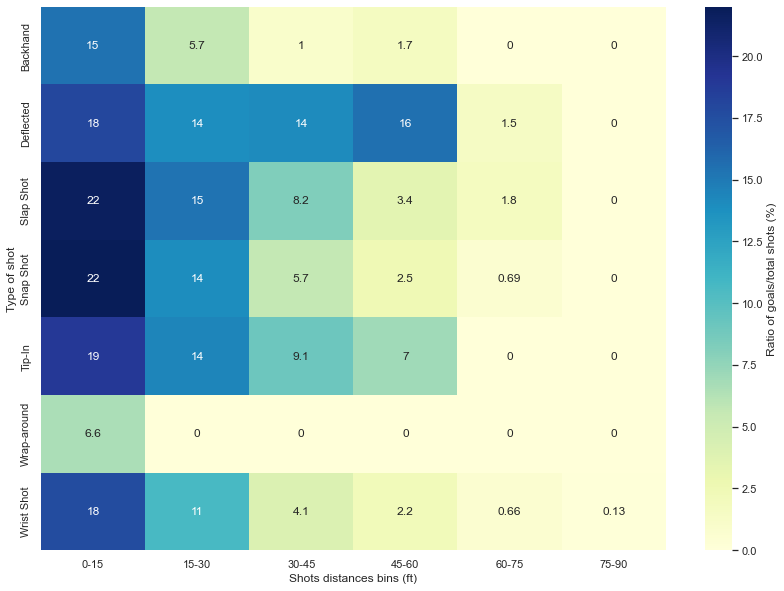

In [32]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(
    ratios,
    xticklabels=['{}-{}'.format(bin, bin+15) for bin in distance_bins[:6]],
    yticklabels=[list(df_grouped.index)[i][0] for i in range(0, len(df_grouped.index), 26)],
    annot=True,
    cmap="YlGnBu",
    ax=ax,
    cbar_kws={'label': 'Ratio of goals/total shots (%)'}
)
ax.set_ylabel('Type of shot')
ax.set_xlabel('Shots distances bins (ft)')
fig.savefig('5-3.png')

plt.show()

**Answer**

*Cette heatmap nous permet d'obeserver les différents ratio de buts marqués par rapport aux tirs tentés de la saison 2018-2019 suivant deux paramètres: la distance de tirs discrétisé sur des intervalles de 15ft et le type de tir tenté. À noter là encore que nous avons décider de ne pas prendre en compte les tirs au delà de 90ft ainsi que les configurations pour lesquelles le nombre de tirs n'étaient pas supérieurs à 30. Ceux-ci auraient démontrés des ratios potentiellement très élevés et non représentatifs d'une saison entière. Suite à cela et grâce au graphique de type Heatmap présenté, nous pouvons identifié les 2 configurations les plus dangereuses: le "Slap Shot" et le "Snap Shot" à une distance d'au maximum 15ft. Ceux-ci présentent un ratio de conversion d'environ 22%.*